In [137]:
import numpy as np
from scipy.optimize import minimize

def fitr2(X, Pold, Pnew, NS, model):
    # Determine parameters based on the model and input dimensions
    if model == 1 and X.shape[0] == 6:
        go, ro, bo, gn, rn, bn = X
    elif model == 1 and X.shape[0] == 4:
        go, ro, bo, gn = X[0], X[1], X[3], X[0]
        rn, bn = X[2], X[3]
    elif model == 2 and X.shape[0] == 3:
        g, ro, rn = X
    elif model == 3 and X.shape[0] == 2:
        bo, bn = X
    else:
        raise ValueError("Invalid model or input dimension for X")

    naOld = NS * Pold
    nbOld = NS * (1 - Pold)
    naNew = NS * Pnew
    nbNew = NS * (1 - Pnew)

    t = np.arange(11)

    if model == 1:  # exemplar
        prOld = 1 / (1 + bo * np.exp(-ro * (go ** t)))
        prNew = 1 / (1 + bn * np.exp(-rn * (gn ** t)))
    elif model == 2:  # power
        prOld = ro * (1 + t) ** g
        prNew = rn * (1 + t) ** g
    else:  # baseline
        prOld = bo * np.ones(11)
        prNew = bn * np.ones(11)

    pr = np.column_stack((prOld, prNew))

    GROld = np.dot(naOld, np.log(prOld)) + np.dot(nbOld, np.log(1 - prOld))
    GRNew = np.dot(naNew, np.log(prNew)) + np.dot(nbNew, np.log(1 - prNew))
    GR = GROld + GRNew

    GCOld = np.dot(naOld, np.log(Pold)) + np.dot(nbOld, np.log(1 - Pold))
    GCNew = np.dot(naNew, np.log(Pnew)) + np.dot(nbNew, np.log(1 - Pnew))
    GC = GCOld + GCNew

    G = 2 * (GC - GR)  # G-squared difference

    return G, pr


Initial results for subject 1: 4.916284217459008
Final results for subject 1: 1.312292042040383
Initial results for subject 2: 8.130710146022011
Final results for subject 2: 1.142282205041795
Initial results for subject 3: 6.142575762397939
Final results for subject 3: 1.0291781442468277
Initial results for subject 4: 5.208451572427521
Final results for subject 4: 0.5394847810426313
Initial results for subject 5: 6.117120311128531
Final results for subject 5: 0.6024822561441852
G-squared difference for each subject, last row is the mean:
[1.31229204 1.14228221 1.02917814 0.53948478 0.60248226 0.92514389]
Mean parameters:
[0.70172817 2.98064924 2.10812032 0.92939992]
Mean observed Old, Mean observed New:
[[0.949 0.906]
 [0.895 0.818]
 [0.833 0.746]
 [0.75  0.692]
 [0.689 0.648]
 [0.633 0.595]
 [0.618 0.569]
 [0.568 0.558]
 [0.584 0.57 ]
 [0.534 0.533]
 [0.533 0.548]]
Mean predicted Old, Mean predicted New:
[[0.95333087 0.89776308]
 [0.89579985 0.82480789]
 [0.82260635 0.75209258]
 [0.74

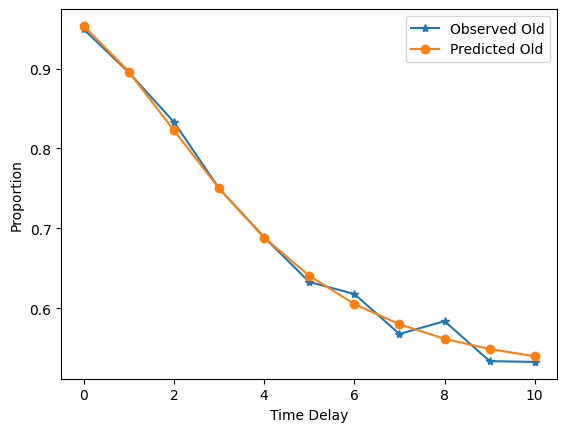

In [138]:
# Load data (replace with actual data loading code)
SPOld = np.load("NormalOldData.npy")  # Replace with correct file paths
SPNew = np.load("NormalNewData.npy")

ns = SPOld.shape[1]  # number of subjects
nd = SPOld.shape[0]  # number of delays

model = 1  # exemplar model

if model == 1:
    X0 = np.array([0.8, 2.0, 1.0, 1.0])  # initial guess for exemplar model
    #X0 = np.array([0.8, 2.0, 1.0, 0.8, 1.0, 1.0])
elif model == 2:
    X0 = np.array([-0.2, 0.9, 0.8])  # initial guess for power model
else:
    X0 = np.array([0.6, 0.6])  # initial guess for baseline model

ChiM = np.zeros(ns)
Parms = np.zeros((len(X0), ns))
PredMold = np.zeros((nd, ns))
PredMnew = np.zeros((nd, ns))

for sub in range(ns):
    Pold = SPOld[:, sub]
    Pnew = SPNew[:, sub]

    # Initial results
    G, pr = fitr2(X0, Pold, Pnew, nd, model)
    print(f"Initial results for subject {sub + 1}: {G}")

    # Optimization
    result = minimize(lambda X: fitr2(X, Pold, Pnew, nd, model)[0], X0, method='Nelder-Mead')
    X_opt = result.x
    G_opt = result.fun

    # Final results
    print(f"Final results for subject {sub + 1}: {G_opt}")

    ChiM[sub] = G_opt
    Parms[:, sub] = X_opt
    G, pr = fitr2(X_opt, Pold, Pnew, nd, model)
    PredMold[:, sub] = pr[:, 0]
    PredMnew[:, sub] = pr[:, 1]

print("G-squared difference for each subject, last row is the mean:")
print(np.append(ChiM, np.mean(ChiM)))

print("Mean parameters:")
print(np.mean(Parms, axis=1))

print("Mean observed Old, Mean observed New:")
print(np.column_stack((np.mean(SPOld, axis=1), np.mean(SPNew, axis=1))))

print("Mean predicted Old, Mean predicted New:")
print(np.column_stack((np.mean(PredMold, axis=1), np.mean(PredMnew, axis=1))))

# Plot the results
import matplotlib.pyplot as plt

t = np.arange(11)
plt.plot(t, np.mean(SPOld, axis=1), '*-', label='Observed Old')
plt.plot(t, np.mean(PredMold, axis=1), 'o-', label='Predicted Old')
plt.xlabel('Time Delay')
plt.ylabel('Proportion')
plt.legend()
plt.show()


In [168]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
import pandas as pd

def compute_g_squared(log_likelihood_4param, log_likelihood_6param):
    return -2 * (log_likelihood_6param - log_likelihood_4param)

def compute_bic(g_squared, num_params, num_obs):
    return g_squared + num_params * np.log(num_obs)

# Assume SPOld and SPNew are loaded data for old and new stimuli
ns = SPOld.shape[1]  # number of subjects
nd = SPOld.shape[0]  # number of delays
num_obs = 2 * nd * 200  # Total number of observations (old and new for 11 delays, 200 each)

results = []

for sub in range(ns):
    Pold = SPOld[:, sub]
    Pnew = SPNew[:, sub]

    # Run the 4-parameter model
    X0_4param = np.array([0.8, 2.0, 1.0, 1.0])
    result_4param = minimize(lambda X: fitr2(X, Pold, Pnew, nd, 1)[0], X0_4param, method='Nelder-Mead')
    G_4param, _ = fitr2(result_4param.x, Pold, Pnew, nd, 1)

    print("G_4param", G_4param)
    
    # Run the 6-parameter model
    X0_6param = np.array([0.8, 2.0, 1.0, 0.8, 1.0, 1.0])
    result_6param = minimize(lambda X: fitr2(X, Pold, Pnew, nd, 1)[0], X0_6param, method='Nelder-Mead')
    G_6param, _ = fitr2(result_6param.x, Pold, Pnew, nd, 1)

    print("G_6param", G_6param)
    
    # Compute log-likelihood for each model
    log_likelihood_4param = -G_4param / 2
    log_likelihood_6param = -G_6param / 2
    
    # Compute chi-square difference
    chi_square_diff = compute_g_squared(log_likelihood_6param, log_likelihood_4param)
    
    # Compute p-value for the chi-square difference (df = 2 because 6-parameter model has 2 extra parameters)
    p_value = 1.0 - chi2.cdf(chi_square_diff, df=2)
    
    # Compute BIC for each model
    bic_4param = compute_bic(G_4param, 4, num_obs)
    bic_6param = compute_bic(G_6param, 6, num_obs)
    
    # Store results
    results.append({
        "Subject": sub + 1,
        "G^2 Diff": chi_square_diff,
        "p-value": p_value,
        "BIC (4-param)": bic_4param,
        "BIC (6-param)": bic_6param,
        "BIC Diff": bic_6param - bic_4param
    })

# Convert results to a DataFrame and display in Jupyter
df_results = pd.DataFrame(results)
df_results.loc["Mean"] = df_results.mean()
df_results


G_4param 1.312292042040383
G_6param 1.0528640228235986
G_4param 1.142282205041795
G_6param 1.1126537139174388
G_4param 1.0291781442468277
G_6param 0.9360342623753013
G_4param 0.5394847810426313
G_6param 0.5105477914201515
G_4param 0.6024822561441852
G_6param 0.5861769477356233


,Subject,G^2 Diff,p-value,BIC (4-param),BIC (6-param),BIC Diff
0,1.0,0.259428,0.878347,34.869731,51.389023,16.519292
1,2.0,0.029628,0.985295,34.699721,51.448813,16.749091
2,3.0,0.093144,0.954496,34.586617,51.272193,16.685576
3,4.0,0.028937,0.985636,34.096924,50.846707,16.749783
4,5.0,0.016305,0.991880,34.159922,50.922336,16.762414
Mean,3.0,0.085489,0.959131,34.482583,51.175814,16.693231


In [13]:
chi_square_diff = 6.0  # Artificially set a high value for testing
p_value = 1 - chi2.cdf(chi_square_diff, df=2)
print(f"Chi-square Diff: {chi_square_diff}, p-value: {p_value}")

Chi-square Diff: 6.0, p-value: 0.04978706836786395


In [196]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Number of qubits
N = 4

# Use a device that supports noise channels.
dev = qml.device("default.mixed", wires=N)

def simulate_quantum_model(params):
    # Define parameters: beta, gamma for the Hamiltonians and a decay_rate for the amplitude damping
    #beta = 1.0
    #gamma = 0.5
    #decay_rate = 0.033  # Adjusted decay rate: at t=10, P_excited ~ exp(-0.0636*10) ≈ 0.53
    beta, gamma, decay_rate = params
    
    # Construct coefficients for H_final using the loaded data
    J_i = beta * SPOld.mean(axis=1)[:N]
    J_ij = gamma * np.outer(SPNew.mean(axis=1)[:N], SPNew.mean(axis=1)[:N])
    # Only take the unique (i, j) pairs
    J_ij_flat = [J_ij[i, j] for i in range(N) for j in range(i + 1, N)]
    
    coeffs = list(J_i) + J_ij_flat
    ops = [qml.PauliZ(i) for i in range(N)] + [
        qml.PauliZ(i) @ qml.PauliZ(j) for i in range(N) for j in range(i + 1, N)
    ]
    H_final = qml.Hamiltonian(coeffs, ops)
    
    # Define a transverse field Hamiltonian H_initial
    coeffs_initial = [-1.0] * N
    ops_initial = [qml.PauliX(i) for i in range(N)]
    H_initial = qml.Hamiltonian(coeffs_initial, ops_initial)
    
    # Combine them to get the unitary part of the evolution.
    H_total = H_initial + H_final
    
    # Define the unitary time evolution via Trotterization.
    def time_evolution(time):
        qml.templates.ApproxTimeEvolution(H_total, time, 100)
    
    @qml.qnode(dev)
    def circuit(time):
        # Start in the excited state |1> for each qubit.
        for i in range(N):
            qml.PauliX(wires=i)
        
        # Apply the unitary evolution.
        time_evolution(time)
        
        # Model decay using an amplitude damping channel.
        # The damping probability p = 1 - exp(-decay_rate * time)
        p = 1 - np.exp(-decay_rate * time)
        for i in range(N):
            qml.AmplitudeDamping(p, wires=i)
        
        # Measure each qubit's PauliZ expectation value.
        # For amplitude damping, the excited state |1> decays toward |0>, and the probability of being in |1> is given by (1 - <Z>)/2.
        return [qml.expval(qml.PauliZ(i)) for i in range(N)]
    
    # Simulate the evolution over a range of times.
    #time_points = np.linspace(0, 10, 50)
    time_points = np.linspace(0, 10, 11)
    results = np.array([circuit(t) for t in time_points])


    # Convert the measured <Z> values to excitation probabilities:
    # P_excited = (1 - <Z>)/2 for each qubit.
    excited_probs = (1 - results) / 2.0
    
    # Compute the average excitation probability over all qubits.
    avg_excited_prob = excited_probs.mean(axis=1)

    return avg_excited_prob

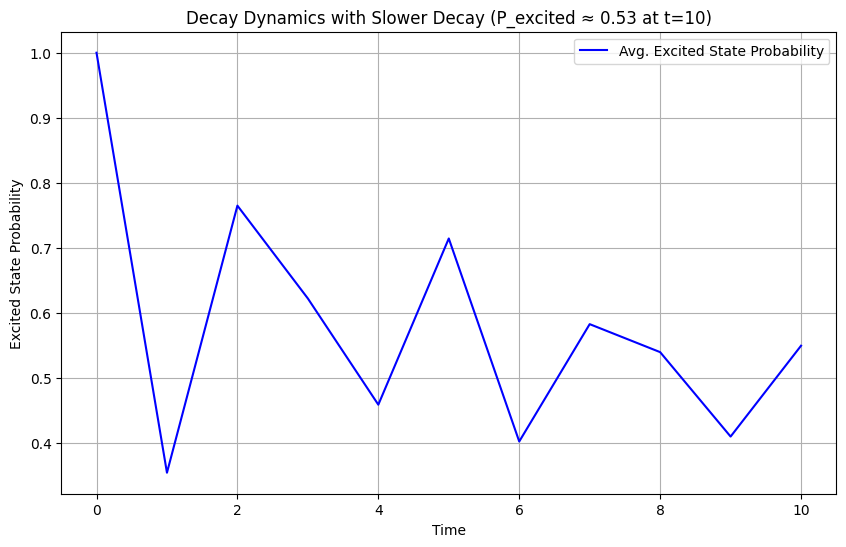

In [197]:
time_points = np.linspace(0, 10, 11)
initial_params = np.array([1.0, 0.5, 0.033])
avg_excited_prob = simulate_quantum_model(initial_params)
# Plot the decay of the excited state population over time.
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_excited_prob, label="Avg. Excited State Probability", color='blue')
plt.xlabel("Time")
plt.ylabel("Excited State Probability")
plt.title("Decay Dynamics with Slower Decay (P_excited ≈ 0.53 at t=10)")
plt.legend()
plt.grid(True)
plt.show()


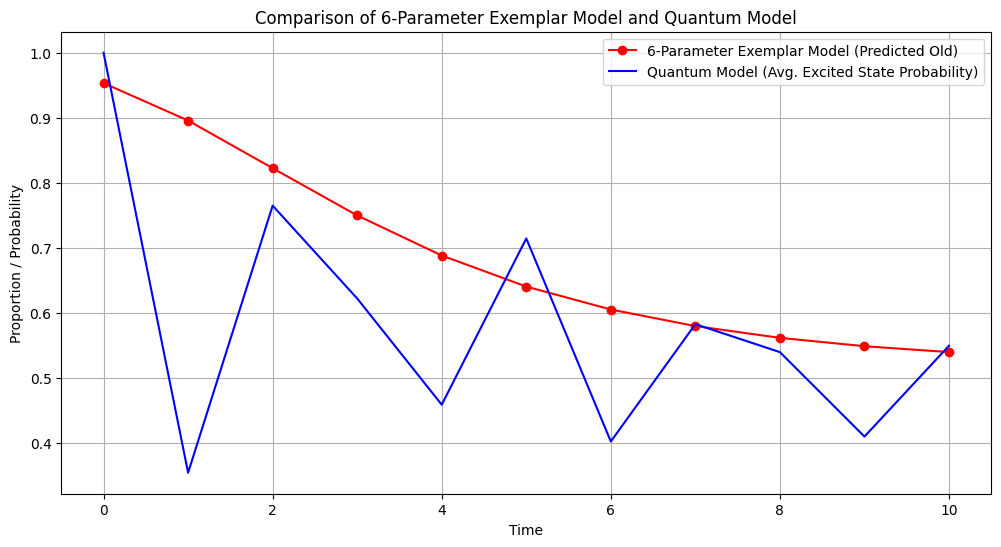

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean predicted proportion of "old" responses from the exemplar model.
# (Make sure that PredMold is defined or loaded elsewhere.)
mean_pred_old = np.mean(PredMold, axis=1)  # shape should be (number_of_time_points_exemplar,)

# Assume that from your quantum simulation you have:
# - avg_excited_prob: the average excited state probability (or equivalently, the decayed P_old) at each time point.
# - time_points_quantum: the corresponding time points (e.g., np.linspace(0, 10, 50))
# For example:
# time_points_quantum = np.linspace(0, 10, 50)
# avg_excited_prob = ... (computed from the simulation)

# Set up the figure.
plt.figure(figsize=(12, 6))

# Plot the 6-parameter exemplar model results.
# Here we assume there are 11 time points for the exemplar model.
time_points_exemplar = np.arange(len(mean_pred_old))
plt.plot(time_points_exemplar, mean_pred_old, 'o-', label='6-Parameter Exemplar Model (Predicted Old)', color='red')

# Plot the quantum model results (decay dynamics as modeled by amplitude damping).
time_points_quantum = np.linspace(0, 10, 11)
initial_params = np.array([1.0, 0.5, 0.033])
avg_excited_prob = simulate_quantum_model(initial_params)
plt.plot(time_points_quantum, avg_excited_prob, '-', label='Quantum Model (Avg. Excited State Probability)', color='blue')

# Customize the plot.
plt.xlabel("Time")
plt.ylabel("Proportion / Probability")
plt.title("Comparison of 6-Parameter Exemplar Model and Quantum Model")
plt.legend()
plt.grid(True)
plt.show()


In [243]:
import numpy as np
from scipy.optimize import minimize

# Define fixed values for parameters that are not optimized
fixed_beta = 1.0
fixed_gamma = 0.5
fixed_decay_rate = 0.033

# Function to select which parameters to optimize
def select_params(num_free_params):
    if num_free_params == 0:
        initial_params = np.array([])  # No parameters to optimize
        bounds = []
    elif num_free_params == 1:
        initial_params = np.array([fixed_decay_rate])
        bounds = [(0.001, 1)]
    elif num_free_params == 2:
        initial_params = np.array([fixed_gamma, fixed_decay_rate])
        bounds = [(0.1, 10), (0.001, 1)]
    elif num_free_params == 3:
        initial_params = np.array([fixed_beta, fixed_gamma, fixed_decay_rate])
        bounds = [(0.1, 10), (0.1, 10), (0.001, 1)]
    else:
        raise ValueError("num_free_params must be 0, 1, 2, or 3")
    
    return initial_params, bounds


# Quantum model with flexible parameter input
def quantum_model(params, time, num_free_params):
    if num_free_params == 0:
        beta = fixed_beta
        gamma = fixed_gamma
        decay_rate = fixed_decay_rate
    elif num_free_params == 1:
        beta = fixed_beta
        gamma = fixed_gamma
        decay_rate = params[0]
    elif num_free_params == 2:
        beta = fixed_beta
        gamma, decay_rate = params[:2]
    elif num_free_params == 3:
        beta, gamma, decay_rate = params[:3]
    else:
        raise ValueError("Invalid number of free parameters")
    
    J_i = beta * SPOld.mean(axis=1)[:N]
    J_ij = gamma * np.outer(SPNew.mean(axis=1)[:N], SPNew.mean(axis=1)[:N])
    J_ij_flat = [J_ij[i, j] for i in range(N) for j in range(i + 1, N)]
    
    coeffs = list(J_i) + J_ij_flat
    ops = [qml.PauliZ(i) for i in range(N)] + [
        qml.PauliZ(i) @ qml.PauliZ(j) for i in range(N) for j in range(i + 1, N)
    ]
    H_total = qml.Hamiltonian(coeffs, ops) + qml.Hamiltonian([-1.0] * N, [qml.PauliX(i) for i in range(N)])
    
    @qml.qnode(dev)
    def circuit(t):
        for i in range(N):
            qml.PauliX(wires=i)
        qml.templates.ApproxTimeEvolution(H_total, t, 100)
        
        p = 1 - np.exp(-decay_rate * t)
        p = np.clip(p, 0, 1)
        
        for i in range(N):
            qml.AmplitudeDamping(p, wires=i)
        
        return [qml.expval(qml.PauliZ(i)) for i in range(N)]
    
    results = np.array([circuit(t) for t in time])
    excited_probs = (1 - results) / 2.0
    avg_excited_prob = excited_probs.mean(axis=1)
    
    return avg_excited_prob

In [244]:
# Objective function with flexible parameters
def objective(params):
    time_points = np.linspace(0, 10, 11)
    predicted = quantum_model(params, time_points, num_free_params)
    
    observed_old = SPOld.mean(axis=1)
    observed_new = SPNew.mean(axis=1)
    
    epsilon = 1e-10
    predicted = np.clip(predicted, epsilon, 1 - epsilon)
    observed_old = np.clip(observed_old, epsilon, 1 - epsilon)
    observed_new = np.clip(observed_new, epsilon, 1 - epsilon)
    
    G_squared = (
        2 * np.sum(observed_old * np.log(observed_old / predicted)) +
        2 * np.sum(observed_new * np.log(observed_new / predicted))
    )
    return G_squared


In [254]:
# Select number of free parameters (0, 1, 2, or 3)
num_free_params = 0  # Change this to 0, 1, 2, or 3

# Get initial parameters and bounds
initial_params, bounds = select_params(num_free_params)

if num_free_params > 0:
    # Optimize the parameters
    result = minimize(objective, initial_params, method='Nelder-Mead', bounds=bounds)
    optimal_params = result.x
    print(f"Optimal parameters with {num_free_params} free parameters:", optimal_params)
else:
    # Directly use fixed parameters without optimization
    time_points = np.linspace(0, 10, 11)
    avg_excited_prob = quantum_model([], time_points, num_free_params)
    print("Average excitation probability with fixed parameters:", avg_excited_prob)


Average excitation probability with fixed parameters: [1.         0.35476805 0.76508913 0.62244437 0.45928888 0.71463016
 0.40274892 0.58301736 0.54002126 0.41031619 0.54988653]


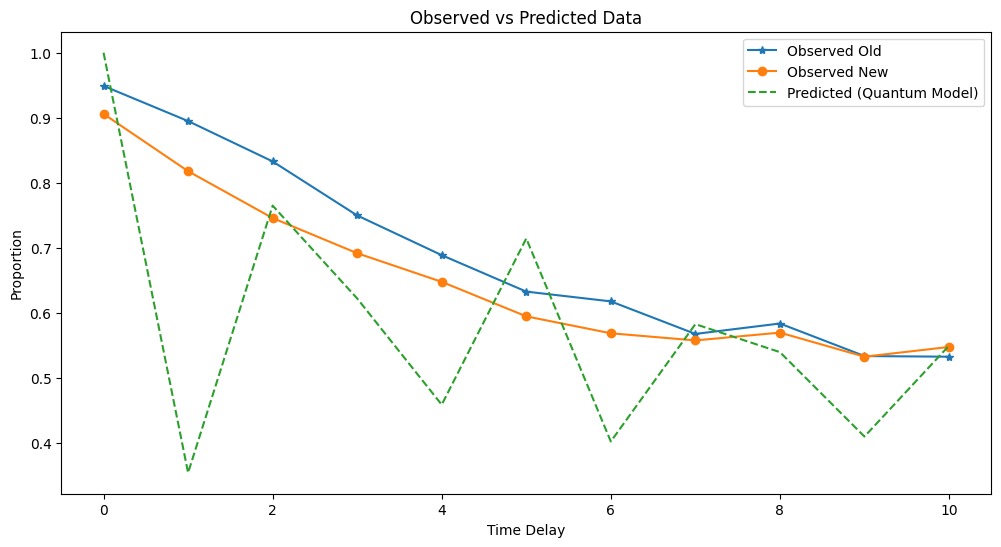

In [255]:
# Plot observed and predicted data
time_points = np.linspace(0, 10, 11)
fixed_params = np.array([1.0, 0.5, 0.033])
predicted = quantum_model(optimal_params, time_points, num_free_params)

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, 10, 11), SPOld.mean(axis=1), '*-', label='Observed Old')
plt.plot(np.linspace(0, 10, 11), SPNew.mean(axis=1), 'o-', label='Observed New')
plt.plot(time_points, predicted, '--', label='Predicted (Quantum Model)')
plt.xlabel('Time Delay')
plt.ylabel('Proportion')
plt.legend()
plt.title('Observed vs Predicted Data')
plt.show()


In [256]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
import pandas as pd

def compute_bic(g_squared, num_params, num_obs):
    """Compute BIC given G-squared, number of parameters, and number of observations."""
    return g_squared + num_params * np.log(num_obs)

# Number of observations (old and new for 11 delays, 200 each)
num_obs = 2 * 11 * 200

results = []

for sub in range(SPOld.shape[1]):  # Iterate over subjects
    Pold = SPOld[:, sub]
    Pnew = SPNew[:, sub]

    # Run the 4-parameter model
    X0_4param = np.array([0.8, 2.0, 1.0, 1.0])  # Initial guess for 4-parameter model
    result_4param = minimize(lambda X: fitr2(X, Pold, Pnew, 11, 1)[0], X0_4param, method='Nelder-Mead')
    G_4param, _ = fitr2(result_4param.x, Pold, Pnew, 11, 1)
    
    # Simulate the new quantum model and compute G-squared
    time_points = np.linspace(0, 10, 11)  # Match time points to delays
    predicted_prob = quantum_model(fixed_params, time_points, num_free_params)
    
    # Compute G-squared for the quantum model
    epsilon = 1e-10  # Prevent log(0)
    predicted_prob = np.clip(predicted_prob, epsilon, 1 - epsilon)
    observed_old = np.clip(Pold, epsilon, 1 - epsilon)
    observed_new = np.clip(Pnew, epsilon, 1 - epsilon)
    G_quantum = (
        2 * np.sum(observed_old * np.log(observed_old / predicted_prob)) +
        2 * np.sum(observed_new * np.log(observed_new / predicted_prob))
    )

    # Compute log-likelihoods
    log_likelihood_4param = -G_4param / 2
    log_likelihood_quantum = -G_quantum / 2
    
    # Compute BIC for both models
    bic_4param = compute_bic(G_4param, 4, num_obs)
    bic_quantum = compute_bic(G_quantum, 3, num_obs)  # New quantum model has 3 parameters (beta, gamma, decay_rate)
    
    # Store results
    results.append({
        "Subject": sub + 1,
        "G^2 (4-param)": G_4param,
        "G^2 (Quantum)": G_quantum,
        "BIC (4-param)": bic_4param,
        "BIC (Quantum)": bic_quantum,
        "BIC Diff": bic_quantum - bic_4param
    })

# Convert all tensor objects to float in the DataFrame
df_results = pd.DataFrame(results)

# Apply conversion to numeric for all columns
for col in ["G^2 (4-param)", "G^2 (Quantum)", "BIC (4-param)", "BIC (Quantum)", "BIC Diff"]:
    df_results[col] = df_results[col].apply(lambda x: float(x.detach().numpy()) if hasattr(x, 'detach') else float(x))

# Compute the mean for each column and add it as a new row
df_results.loc["Mean"] = df_results.mean()

# Display the DataFrame with the results and the mean row
df_results



,Subject,G^2 (4-param),G^2 (Quantum),BIC (4-param),BIC (Quantum),BIC Diff
0,1.0,1.312292,5.358649,34.869731,30.526728,-4.343003
1,2.0,1.142282,5.468296,34.699721,30.636375,-4.063346
2,3.0,1.029178,5.281923,34.586617,30.450002,-4.136615
3,4.0,0.539485,5.323879,34.096924,30.491959,-3.604965
4,5.0,0.602482,5.861470,34.159922,31.029549,-3.130372
Mean,3.0,0.925144,5.458843,34.482583,30.626923,-3.855660


In [257]:
# Compute BIC for each model
bic_4param = compute_bic(G_4param, 4, num_obs)  # 4 parameters for the 4-parameter model
bic_quantum = compute_bic(G_quantum, num_free_params, num_obs)

# Compute the BIC difference
bic_diff = bic_quantum - bic_4param

# Display the BIC comparison
print(f"BIC (4-parameter model): {bic_4param}")
print(f"BIC (Quantum model): {bic_quantum}")
print(f"BIC Difference (Quantum - 4-param): {bic_diff}")

# Interpretation
if bic_diff > 10:
    print("Strong evidence for the 4-parameter model.")
elif 6 < bic_diff <= 10:
    print("Moderate evidence for the 4-parameter model.")
elif 2 < bic_diff <= 6:
    print("Weak evidence for the 4-parameter model.")
else:
    print("Minimal evidence; both models are comparable.")


BIC (4-parameter model): 34.1599215357696
BIC (Quantum model): 5.861469865962457
BIC Difference (Quantum - 4-param): -28.298451669807143
Minimal evidence; both models are comparable.


Mean parameter estimates for Amnesic Old participants:
[0.49417032 1.91249658 1.19800114 0.50847367 1.53356597 1.53856194]
Mean parameter estimates for Normal Old participants:
[0.71608853 2.96618168 0.9721701  0.67504341 2.12576886 0.89056574]


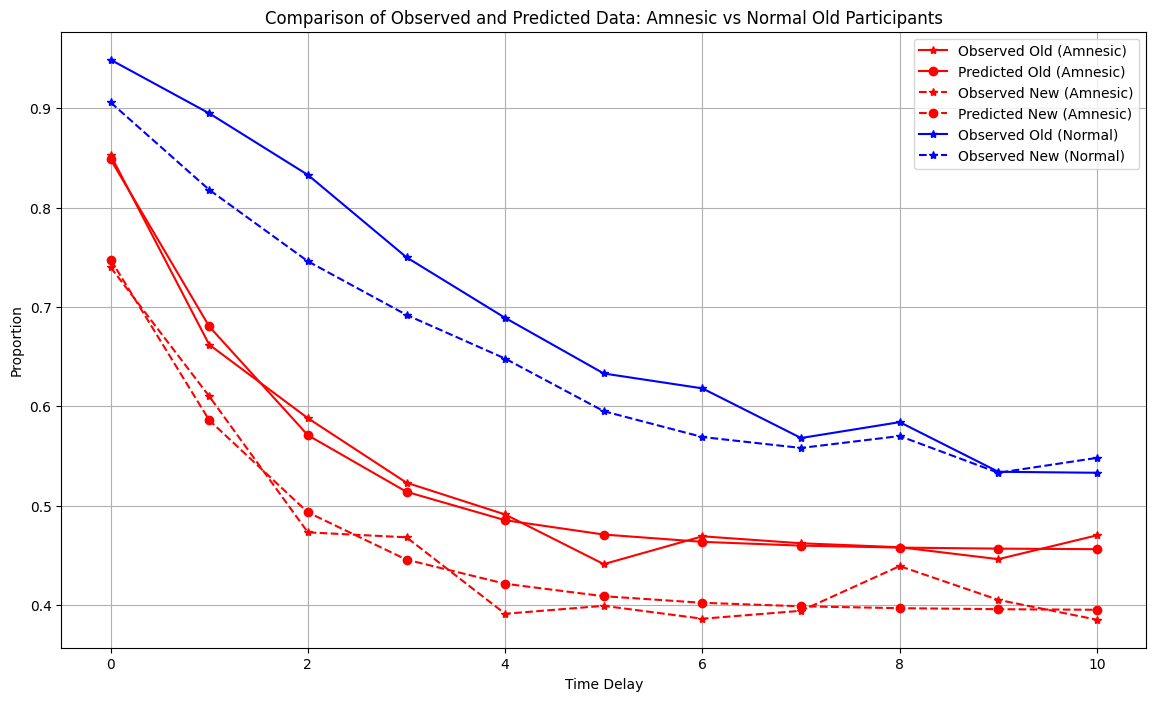

In [259]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load data for Amnesic Old and New participants
SPOld_amnesic = np.load("AmnesicOldData.npy")
SPNew_amnesic = np.load("AmnesicNewData.npy")

# Load data for Normal Old participants from Problem 2
SPOld_normal = np.load("NormalOldData.npy")
SPNew_normal = np.load("NormalNewData.npy")

ns_amnesic = SPOld_amnesic.shape[1]
nd = SPOld_amnesic.shape[0]
model = 1  # exemplar model

# Initial guess for 6-parameter model
X0 = np.array([0.8, 2.0, 1.0, 0.8, 1.0, 1.0])

# Fitting for Amnesic participants
ChiM_amnesic = np.zeros(ns_amnesic)
Parms_amnesic = np.zeros((len(X0), ns_amnesic))
PredMold_amnesic = np.zeros((nd, ns_amnesic))
PredMnew_amnesic = np.zeros((nd, ns_amnesic))

for sub in range(ns_amnesic):
    Pold = SPOld_amnesic[:, sub]
    Pnew = SPNew_amnesic[:, sub]

    # Fit the 6-parameter model
    result = minimize(lambda X: fitr2(X, Pold, Pnew, nd, model)[0], X0, method='Nelder-Mead')
    X_opt = result.x
    G_opt = result.fun

    # Store results
    ChiM_amnesic[sub] = G_opt
    Parms_amnesic[:, sub] = X_opt
    G, pr = fitr2(X_opt, Pold, Pnew, nd, model)
    PredMold_amnesic[:, sub] = pr[:, 0]
    PredMnew_amnesic[:, sub] = pr[:, 1]

# Calculate mean parameter estimates for Amnesic participants
mean_params_amnesic = np.mean(Parms_amnesic, axis=1)
print("Mean parameter estimates for Amnesic Old participants:")
print(mean_params_amnesic)

# Fitting for Normal Old participants (using the provided Problem 2 code)
ns_normal = SPOld_normal.shape[1]
ChiM_normal = np.zeros(ns_normal)
Parms_normal = np.zeros((len(X0), ns_normal))

for sub in range(ns_normal):
    Pold = SPOld_normal[:, sub]
    Pnew = SPNew_normal[:, sub]

    # Fit the 6-parameter model
    result = minimize(lambda X: fitr2(X, Pold, Pnew, nd, model)[0], X0, method='Nelder-Mead')
    X_opt = result.x
    Parms_normal[:, sub] = X_opt

# Calculate mean parameter estimates for Normal Old participants
mean_params_normal = np.mean(Parms_normal, axis=1)
print("Mean parameter estimates for Normal Old participants:")
print(mean_params_normal)

# Plot observed vs predicted data for Amnesic participants
# Plot observed vs predicted data for both Amnesic and Normal Old participants
t = np.arange(11)
plt.figure(figsize=(14, 8))

# Amnesic participants
plt.plot(t, np.mean(SPOld_amnesic, axis=1), 'r*-', label='Observed Old (Amnesic)')
plt.plot(t, np.mean(PredMold_amnesic, axis=1), 'ro-', label='Predicted Old (Amnesic)')
plt.plot(t, np.mean(SPNew_amnesic, axis=1), 'r*--', label='Observed New (Amnesic)')
plt.plot(t, np.mean(PredMnew_amnesic, axis=1), 'ro--', label='Predicted New (Amnesic)')

# Normal Old participants
plt.plot(t, np.mean(SPOld_normal, axis=1), 'b*-', label='Observed Old (Normal)')
plt.plot(t, np.mean(SPNew_normal, axis=1), 'b*--', label='Observed New (Normal)')

plt.xlabel('Time Delay')
plt.ylabel('Proportion')
plt.title('Comparison of Observed and Predicted Data: Amnesic vs Normal Old Participants')
plt.legend()
plt.grid(True)
plt.show()

